In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import itertools

In [2]:
challenge_set_df = pd.read_csv('../../data/encoded_challenge_set.csv')

display(challenge_set_df)

,flight_id,month-day,month,day_in_month,adep,country_code_adep,ades,country_code_ades,aircraft_type,wtc,...,altitude_mean,groundspeed_mean,track_mean,vertical_rate_mean,track_unwrapped_mean,u_component_of_wind_mean,v_component_of_wind_mean,temperature_mean,specific_humidity_mean,tow
0,248763780,0,1,1,69,37,79,34,4,1,...,20996.873271,317.161594,266.904445,12.768124,266.904445,31.354330,28.956784,244.875034,0.001527,54748.000000
1,248760618,0,1,1,216,33,165,78,18,0,...,30316.293173,425.555502,253.416154,66.719357,254.283623,21.483643,-8.009300,227.431051,0.000523,185441.000000
2,248753824,0,1,1,137,88,168,78,7,0,...,28087.460730,346.017174,234.214404,-35.945267,226.498682,28.988018,5.062526,225.055003,0.000467,230396.000000
3,248753852,0,1,1,338,19,169,78,21,0,...,31606.355298,405.077422,260.254022,80.900909,177.655929,32.200133,2.404330,227.891101,0.000931,157615.000000
4,248755934,0,1,1,92,44,58,27,1,1,...,14895.710572,354.972270,131.665419,2754.662045,131.665419,22.697229,20.421709,255.205584,0.001545,70318.447226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369008,258058361,364,12,31,253,36,165,78,21,0,...,27520.238596,352.816281,258.075719,105.885193,258.075719,41.300959,34.816118,230.600595,0.001169,163438.000000
369009,258071247,364,12,31,385,96,15,19,1,1,...,31307.635402,358.665526,312.942321,-74.184695,312.942321,16.449682,-17.756664,222.159498,0.000440,78707.000000
369010,258059152,364,12,31,30,26,80,34,4,1,...,27064.704323,306.001767,278.353987,-246.922841,279.965484,48.607200,26.609141,229.831493,0.001106,62942.750000
369011,258072276,364,12,31,253,36,80,34,1,1,...,29506.571457,302.045249,299.062133,-271.516294,299.062133,45.752148,27.416125,225.945456,0.000713,72611.161024


In [3]:
def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
def test_model(df):
    features_names = [
        'flown_distance', 'flight_duration', 'wtc', 'arrival_time_hour', 'arrival_time_hour_minute', 'actual_offblock_time_hour', 
        'actual_offblock_time_hour_minute', 'country_code_adep', 'country_code_ades', 'taxiout_time', 'airline', 'month-day', 'month', 
        'adep', 'ades', 'aircraft_type'
    ]
    target = 'tow'
    features = df[features_names]
    target = df[target]
    X_array = features.values
    y_array = target.values

    mse_scores = []

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    for train_index, test_index in kf.split(X_array):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
        model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

        # Train the model
        model.fit(X_train, y_train)
    
        # Predict
        y_pred = model.predict(X_test)
    
        mse_scores.append(rmse(y_test, y_pred))
    
    return np.mean(mse_scores)

In [4]:
test_model(df=challenge_set_df)

3814.4208399148415

In [5]:
def draw_scatter(df, x, y, c):
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(df[x], df[y], c=df[c], cmap='viridis', alpha=0.7)
    plt.title(f'Scatter Plot of {x} and their {y} showing their {c} as a color label')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(scatter, label=c)
    plt.grid(True)
    plt.show()

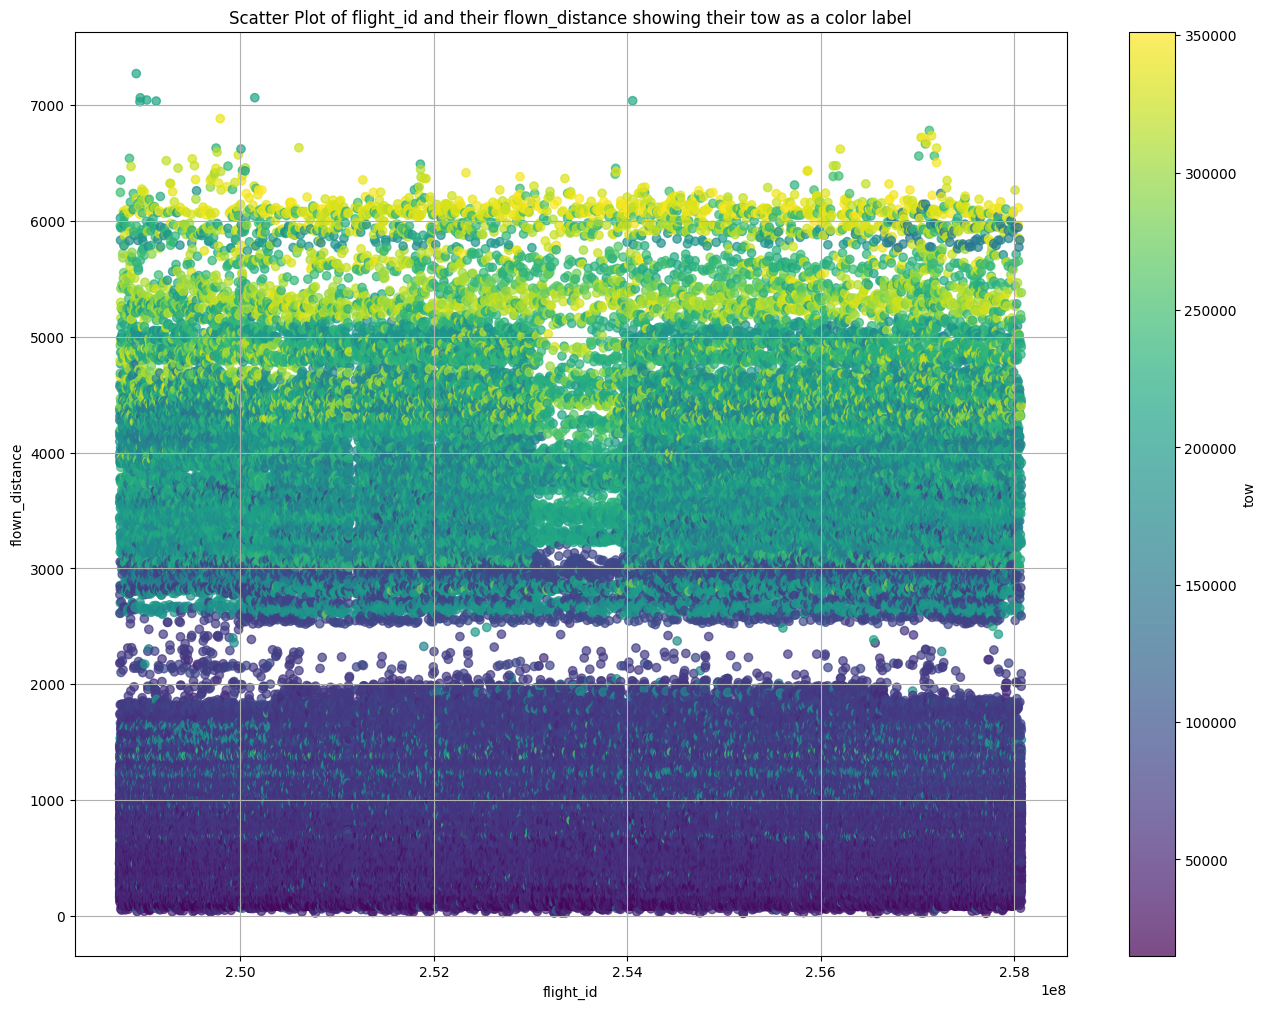

In [6]:
draw_scatter(df=challenge_set_df, x="flight_id", y="flown_distance", c="tow")

In [7]:
washed_df = challenge_set_df[~challenge_set_df['flown_distance'].between(2500, 3000)]
print(len(washed_df))
test_model(df=washed_df)

364184


3802.0637743257703

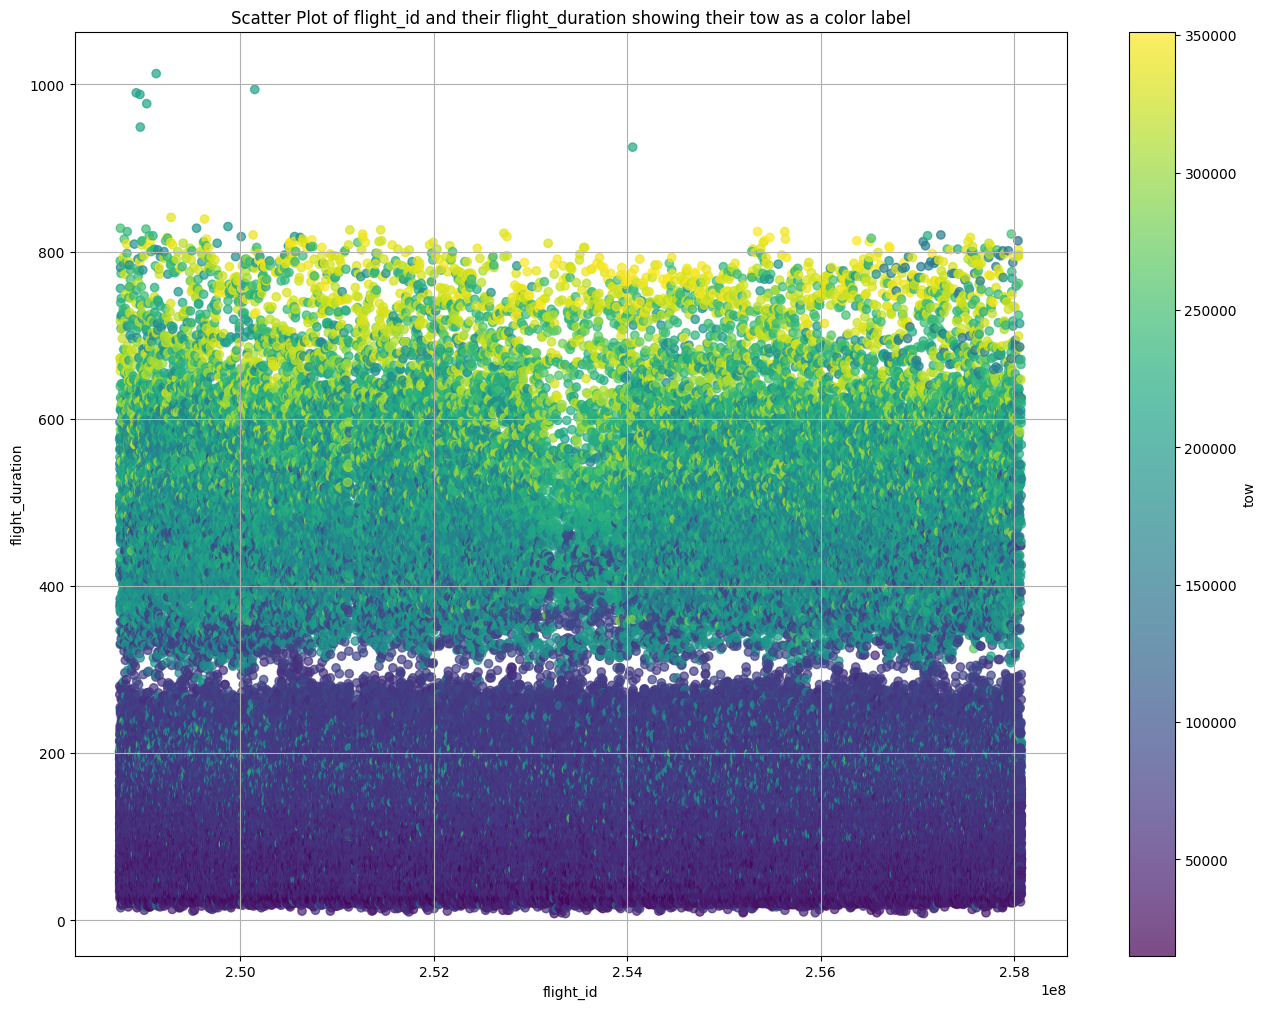

In [8]:
draw_scatter(df=challenge_set_df, x="flight_id", y="flight_duration", c="tow")

In [9]:
washed_df = washed_df[~washed_df['flight_duration'].between(300, 400)]
print(len(washed_df))
test_model(df=washed_df)

360662


3753.74661878657